最終課題で具体的にどのような要件が求められているかについては、最終課題RAEDMEをご覧ください。ここでは最終課題の取り組み方のサンプルとして、第二回のコンペのHome credit社のデータを利用してHome credit社での事業提案例を考えてみます。
**実際の最終課題では、このHome Credit社のデータを用いているとは限らないので、最終課題で指定されたデータセットを解析してください。**
データ分析や機械学習を行うことで、その企業の課題やニーズを見出し、問題解決に役立てる事業を提案してみましょう。

In [ ]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/My Drive/GCI_2022_Summer/Competitions/competition2/input/train.csv')
#df_test = pd.read_csv('/content/drive/My Drive/GCI_2022_Summer/Competitions/competition2/Input/test.csv')
#今回は最終課題を想定してdf_testは使わないことにします。
#pathは各自で変更してください。

最初にデータサイズや型、訓練データの最初の10個のデータを確認します。

In [ ]:
print('データのデータ数は{}、変数は{}種類です。'.format(df.shape[0], df.shape[1]))

データのデータ数は171202、変数は51種類です。


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171202 entries, 0 to 171201
Data columns (total 51 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   171202 non-null  int64  
 1   TARGET                       171202 non-null  int64  
 2   NAME_CONTRACT_TYPE           171202 non-null  object 
 3   CODE_GENDER                  171202 non-null  object 
 4   FLAG_OWN_CAR                 136961 non-null  object 
 5   FLAG_OWN_REALTY              136961 non-null  object 
 6   CNT_CHILDREN                 171202 non-null  int64  
 7   AMT_INCOME_TOTAL             171202 non-null  float64
 8   AMT_CREDIT                   171202 non-null  float64
 9   AMT_ANNUITY                  171196 non-null  float64
 10  AMT_GOODS_PRICE              171039 non-null  float64
 11  NAME_TYPE_SUITE              170455 non-null  object 
 12  NAME_INCOME_TYPE             171202 non-null  object 
 13 

In [ ]:
df.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,0,Cash loans,F,N,N,0,112500.0,755190.0,36328.5,675000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.010032,-9233,-878,-333.0,-522,NaN,1,1,1,1,0,0,Core staff,2.0,2,2,0,1,1,0,1,1,School,NaN,0.372591,NaN,0.0,0.0,0.0,0.0,-292.0,NaN,NaN,NaN,NaN
1,1,0,Cash loans,F,N,Y,0,225000.0,585000.0,16893.0,585000.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.008019,-20148,365243,-4469.0,-3436,NaN,1,0,0,1,0,0,NaN,2.0,2,2,0,0,0,0,0,0,XNA,NaN,0.449567,0.553165,0.0,0.0,0.0,0.0,-617.0,0.0,0.0,0.0,1.0
2,2,0,Cash loans,F,N,Y,0,54000.0,334152.0,18256.5,270000.0,Family,State servant,Secondary / secondary special,Married,House / apartment,0.004960,-18496,-523,-3640.0,-2050,NaN,1,1,1,1,1,0,Core staff,2.0,2,2,0,0,0,0,0,0,Postal,NaN,0.569503,NaN,4.0,0.0,4.0,0.0,-542.0,NaN,NaN,NaN,NaN
3,3,0,Cash loans,F,N,Y,0,67500.0,152820.0,8901.0,135000.0,Children,Pensioner,Lower secondary,Widow,House / apartment,0.005002,-24177,365243,-4950.0,-3951,NaN,1,0,0,1,1,0,NaN,1.0,3,3,0,0,0,0,0,0,XNA,NaN,0.105235,0.767523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1,Cash loans,M,N,N,0,157500.0,271066.5,21546.0,234000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,With parents,0.006296,-10685,-697,-5101.0,-3226,NaN,1,1,1,1,0,0,Drivers,2.0,3,3,0,0,0,0,1,1,Business Entity Type 3,0.342344,0.202490,0.669057,0.0,0.0,0.0,0.0,-1243.0,0.0,0.0,0.0,4.0
5,5,1,Cash loans,F,N,Y,0,135000.0,247500.0,19971.0,247500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.018209,-16795,-425,-2796.0,-324,NaN,1,1,0,1,0,0,Cleaning staff,2.0,3,3,0,0,0,0,0,0,Transport: type 4,NaN,0.552871,NaN,0.0,0.0,0.0,0.0,-307.0,NaN,NaN,NaN,NaN
6,6,0,Cash loans,F,N,Y,0,189000.0,332946.0,17127.0,238500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.011657,-14519,-4089,-8110.0,-5499,NaN,1,1,0,1,0,0,Cooking staff,2.0,1,1,0,1,1,0,0,0,Trade: type 3,NaN,0.658005,0.399676,6.0,0.0,6.0,0.0,-1918.0,0.0,0.0,0.0,3.0
7,7,1,Cash loans,M,N,Y,0,157500.0,203760.0,24309.0,180000.0,Unaccompanied,Working,Higher education,Single / not married,House / apartment,0.006671,-8624,-379,-1793.0,-1192,NaN,1,1,0,1,0,0,NaN,1.0,2,2,0,0,0,0,0,0,Business Entity Type 3,NaN,0.287687,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
8,8,0,Cash loans,M,Y,N,1,324000.0,808650.0,22234.5,675000.0,Unaccompanied,State servant,Higher education,Married,House / apartment,0.010643,-14614,-612,-5137.0,-4040,1.0,1,1,0,1,0,0,Managers,3.0,2,2,0,0,0,0,1,1,Military,NaN,0.707878,0.629674,1.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0
9,9,1,Cash loans,F,N,Y,1,180000.0,207117.0,16492.5,171000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.020713,-17604,-5443,-455.0,-916,NaN,1,1,0,1,0,0,Sales staff,3.0,3,3,0,0,0,1,1,0,Self-employed,0.509716,0.277001,NaN,1.0,0.0,1.0,0.0,-905.0,NaN,NaN,NaN,NaN


欠損値の多いカラムが見られることが分かったので、欠損値の数をカウントします。

In [ ]:
df.isnull().sum() 

SK_ID_CURR                          0
TARGET                              0
NAME_CONTRACT_TYPE                  0
CODE_GENDER                         0
FLAG_OWN_CAR                    34241
FLAG_OWN_REALTY                 34241
CNT_CHILDREN                        0
AMT_INCOME_TOTAL                    0
AMT_CREDIT                          0
AMT_ANNUITY                         6
AMT_GOODS_PRICE                   163
NAME_TYPE_SUITE                   747
NAME_INCOME_TYPE                    0
NAME_EDUCATION_TYPE                 0
NAME_FAMILY_STATUS                  0
NAME_HOUSING_TYPE                   0
REGION_POPULATION_RELATIVE          0
DAYS_BIRTH                          0
DAYS_EMPLOYED                       0
DAYS_REGISTRATION                   0
DAYS_ID_PUBLISH                     0
OWN_CAR_AGE                    112992
FLAG_MOBIL                          0
FLAG_EMP_PHONE                      0
FLAG_WORK_PHONE                     0
FLAG_CONT_MOBILE                    0
FLAG_PHONE  

多くのカラムで欠損値があることが分かりました。これだけ欠損値が多いと、単純にカラムを削除するなどの方法ではうまくいかない可能性も考えられます。次に、事業の例として考えやすそうなTARGET(債務不履行の有無)がどのようなデータなのか確認します。

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


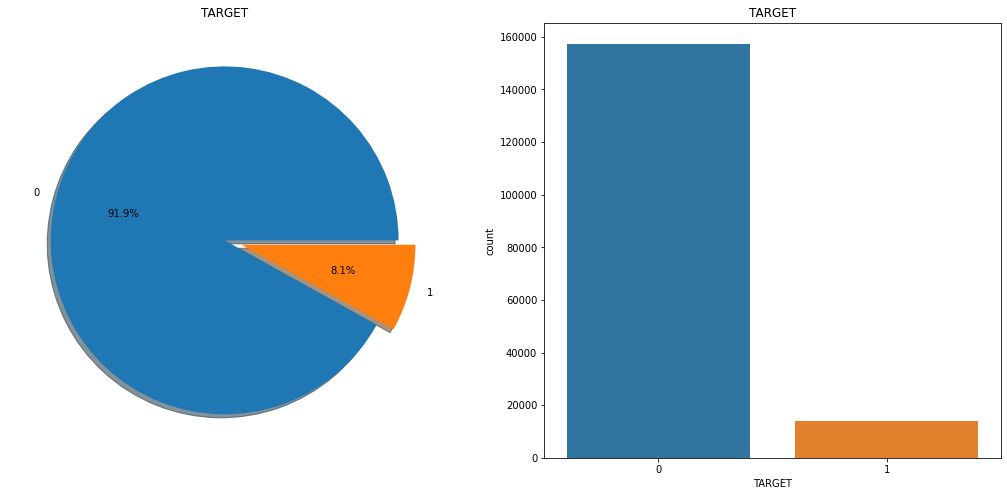

In [ ]:
f,ax=plt.subplots(1,2,figsize=(18,8))
df['TARGET'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('TARGET')
ax[0].set_ylabel('')
sns.countplot('TARGET',data=df,ax=ax[1])
ax[1].set_title('TARGET')
plt.show()

TARGETは不均衡データであることが分かりました。全体についてEDAを行ったり、TARGETについて関連を調べるのも有効ですが(詳しくは、第二回コンペのチューリアルをご覧ください。)、今回は非常にデータが多いので、まずLightGBMでどのような特徴量がTARGETに関連しているのか調べてみることにします。LightGBMは欠損値があっても学習することができるので、今回のデータ分析における機械学習では有効な手段の一つと予測されます。

In [ ]:
df.columns[df.dtypes.values == "object"]

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'ORGANIZATION_TYPE'],
      dtype='object')

In [ ]:
categ_nominal = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'ORGANIZATION_TYPE']

In [ ]:
for i in categ_nominal:
    df = pd.concat([df, pd.get_dummies(df[i], prefix=i, dummy_na=True)], sort=False, axis=1)
df = df.drop(categ_nominal, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171202 entries, 0 to 171201
Columns: 168 entries, SK_ID_CURR to ORGANIZATION_TYPE_nan
dtypes: float64(20), int64(20), uint8(128)
memory usage: 73.1 MB


In [ ]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [ ]:
X = df.drop('TARGET',axis=1) 
y = df['TARGET'] # 目的変数
# トレーニングデータ,テストデータの分割
X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size=0.2, random_state=0)

今回は不均衡データであることから、評価指標にはAUCを用いることにします。適切な評価指標を選ぶことは最終課題でも重要です。

In [ ]:
# 学習に使用するデータを設定
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train) 

# パラメータ
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary', # 目的 : 分類
        'metric': {'auc'},
         'num_leaves': 20,             
        'max_depth':5,
        'min_data_in_leaf': 3,        
        'num_iteration': 100,            
        'learning_rate':0.03,
        'num_boost_round':100,
         'early_stopping_rounds':20, 
}

# モデルの学習
model = lgb.train(params,
                  train_set=lgb_train, # トレーニングデータの指定
                  valid_sets=lgb_eval, # 検証データの指定
                  )

# テストデータの予測
y_pred = model.predict(X_valid)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's auc: 0.696987
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's auc: 0.700242
[3]	valid_0's auc: 0.701235
[4]	valid_0's auc: 0.70423
[5]	valid_0's auc: 0.706714
[6]	valid_0's auc: 0.707278
[7]	valid_0's auc: 0.709475
[8]	valid_0's auc: 0.711478
[9]	valid_0's auc: 0.712248
[10]	valid_0's auc: 0.712193
[11]	valid_0's auc: 0.712423
[12]	valid_0's auc: 0.71285
[13]	valid_0's auc: 0.712908
[14]	valid_0's auc: 0.713409
[15]	valid_0's auc: 0.713271
[16]	valid_0's auc: 0.713423
[17]	valid_0's auc: 0.714198
[18]	valid_0's auc: 0.71454
[19]	valid_0's auc: 0.714816
[20]	valid_0's auc: 0.715438
[21]	valid_0's auc: 0.715746
[22]	valid_0's auc: 0.716447
[23]	valid_0's auc: 0.71717
[24]	valid_0's auc: 0.717567
[25]	valid_0's auc: 0.718024
[26]	valid_0's auc: 0.718423
[27]	valid_0's auc: 0.718764
[28]	valid_0's auc: 0.718964
[29]	valid_0's auc: 0.719522
[30]	valid_0's auc: 0.720009
[31]	valid_0's auc: 0.720292
[32]	valid_0's auc: 0.720884
[33]	valid_0's auc: 0.7

モデルの学習が終わりました。決定木ベースのアンサンブル分析器では特徴量の重要度を算出することができるため、可視化してみます。

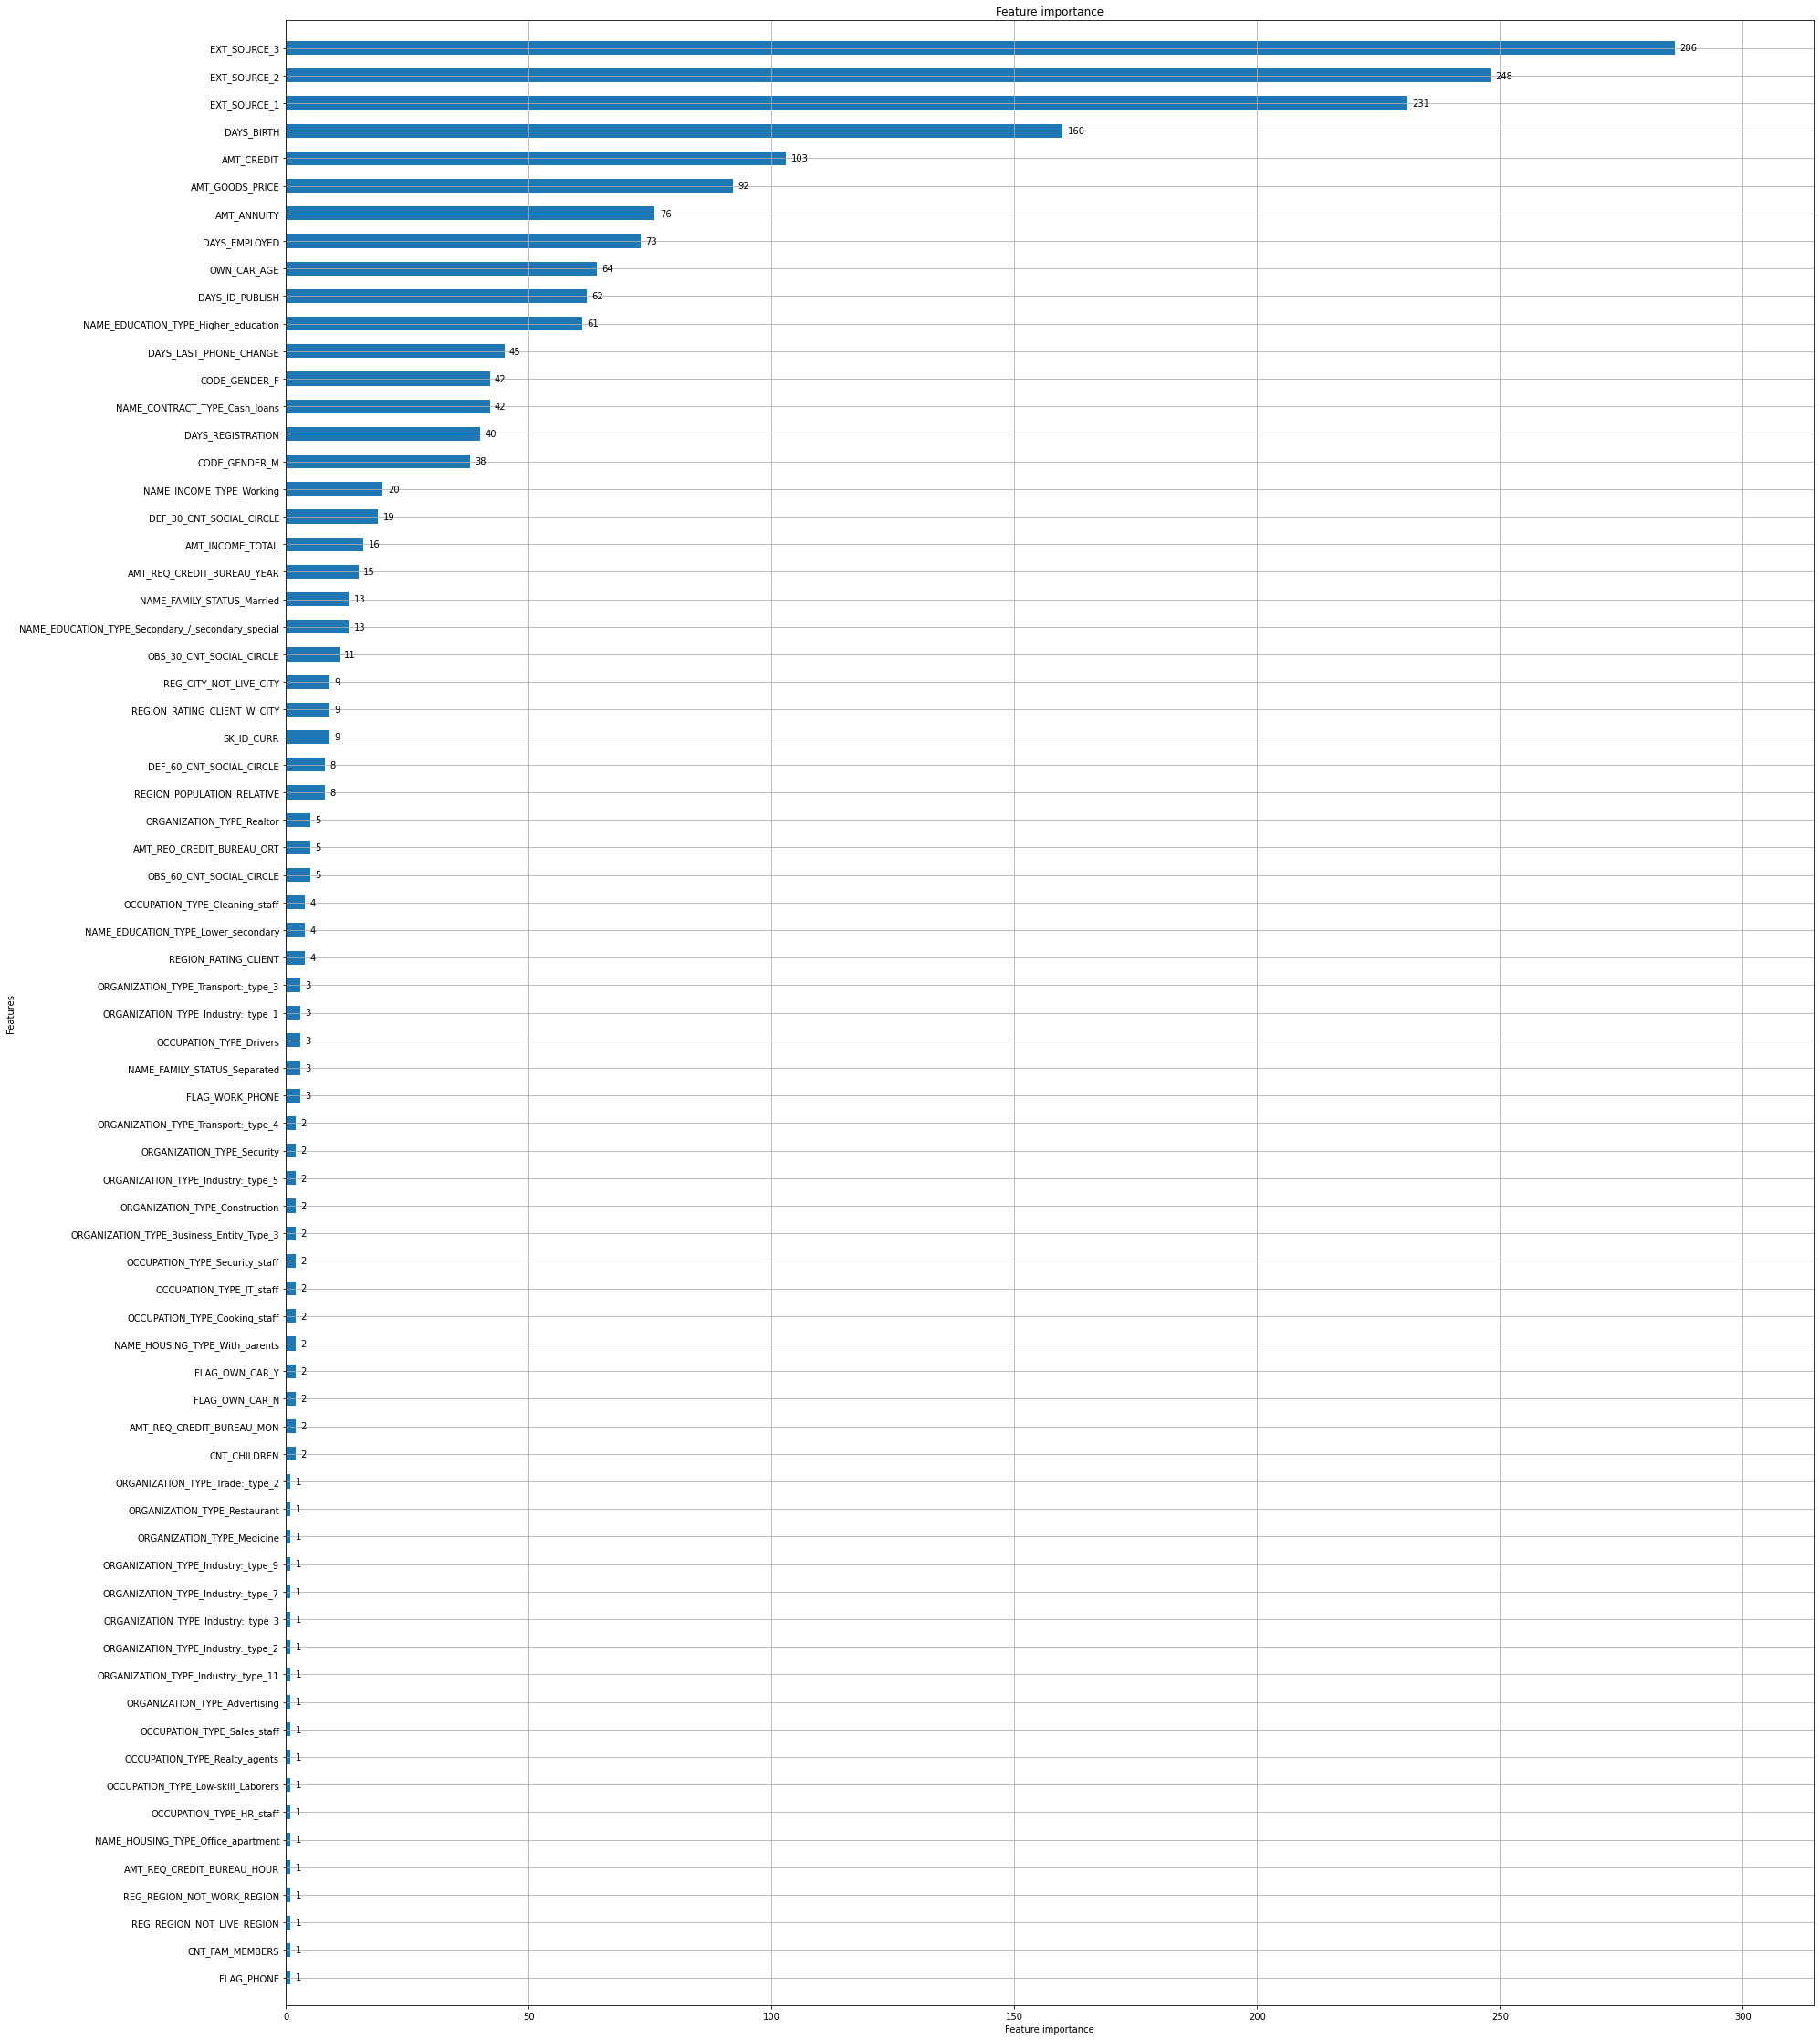

In [ ]:
lgb.plot_importance(model, height=0.5, figsize=(30,40))

モデルの学習に当たって重要と判断された特徴量について可視化することができました。重要と判断された特徴量に関していくつか検討してみることにします。それぞれの特徴量に関して、平均値や中央値、データの分布を確認し、債務不履行の有無でウィルコクソンの順位和検定を有意水準を5%として検定し、2群の中央値に有意差があるか検討してみます。

まずはEXT_SOURCE_1に関して検討します。

In [ ]:
df.groupby(["TARGET"])["EXT_SOURCE_1"].mean()

TARGET
0    0.510937
1    0.387465
Name: EXT_SOURCE_1, dtype: float64

In [ ]:
df.groupby(["TARGET"])["EXT_SOURCE_1"].median()

TARGET
0    0.517352
1    0.361529
Name: EXT_SOURCE_1, dtype: float64

実際に債務不履行の有無によるEXT_SOURCE_1の中央値やヒストグラムを可視化してみましょう。

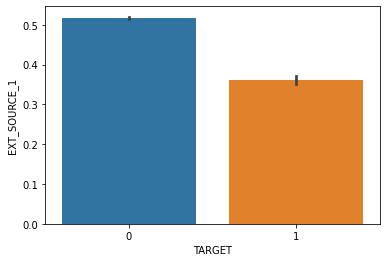

In [ ]:
sns.barplot(x='TARGET', y='EXT_SOURCE_1', data=df, estimator=np.median)

TARGET
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: EXT_SOURCE_1, dtype: object

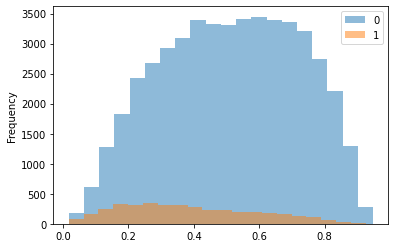

In [ ]:
df.groupby('TARGET')['EXT_SOURCE_1'].plot.hist(bins=20, alpha=0.5, legend=True)

ウィルコクソンの順位和検定を有意水準を5%として検定し、2群の中央値に有意差があるか検討してみます。

In [ ]:
from scipy import stats
s, pvalue = stats.mannwhitneyu(df[df["TARGET"]==1]["EXT_SOURCE_1"]
                , df[df["TARGET"]==0]["EXT_SOURCE_1"]
                ,alternative='two-sided')
pvalue < 0.05

True

この検定より、債務不履行の有無に関してEXT_SOURCE_1には有意差があり、カラム名から察するに外部からの、この信用スコアのようなものが高いと債務不履行になりにくいことが分かりました。反対に、顧客データから顧客の信用スコアを求めることで他社に有益な情報を供与できるかもしれません。信用スコアを他社に提供する分、顧客に還元するアイデアなども考えられます。


次に、DAYS_BIRTHについて検討します。

In [ ]:
df.groupby(["TARGET"])["DAYS_BIRTH"].mean()

TARGET
0   -16148.201136
1   -14874.057015
Name: DAYS_BIRTH, dtype: float64

In [ ]:
df.groupby(["TARGET"])["DAYS_BIRTH"].median()

TARGET
0   -15901.0
1   -14284.0
Name: DAYS_BIRTH, dtype: float64

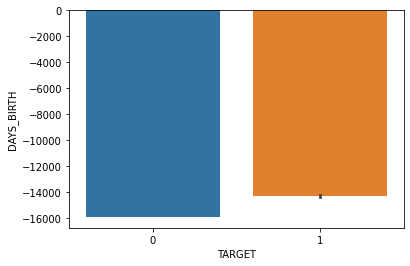

In [ ]:
sns.barplot(x='TARGET', y='DAYS_BIRTH', data=df, estimator=np.median)

TARGET
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: DAYS_BIRTH, dtype: object

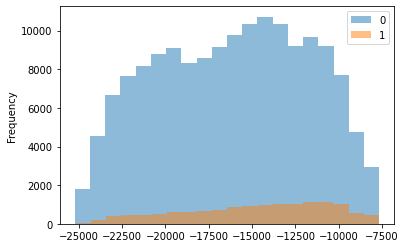

In [ ]:
df.groupby(["TARGET"])["DAYS_BIRTH"].plot.hist(bins=20, alpha=0.5, legend=True)

In [ ]:
s, pvalue = stats.mannwhitneyu(df[df["TARGET"]==1]["DAYS_BIRTH"]
                , df[df["TARGET"]==0]["DAYS_BIRTH"]
                ,alternative='two-sided')
pvalue < 0.05

True

この検定より、債務不履行の有無に関してDAYS_BIRTHには有意差があることが分かりました。値を鑑みるに、年齢は数字の絶対値が小さい方が若いと考えられるので、若い人の方が債務不履行になりやすいと言え、若年層が返済しやすい融資プランの需要があることが予想できます。

次に、AMT_CREDIT(融資額)について検討します。

In [ ]:
df.groupby(["TARGET"])["AMT_CREDIT"].mean()

TARGET
0    603036.026563
1    554643.162796
Name: AMT_CREDIT, dtype: float64

In [ ]:
df.groupby(["TARGET"])["AMT_CREDIT"].median()

TARGET
0    518562.0
1    495000.0
Name: AMT_CREDIT, dtype: float64

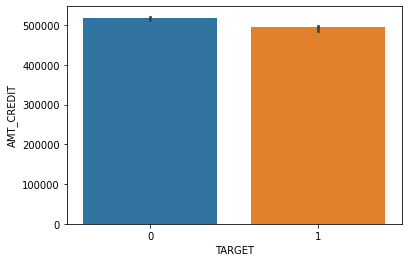

In [ ]:
sns.barplot(x='TARGET', y='AMT_CREDIT', data=df, estimator=np.median)

TARGET
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: AMT_CREDIT, dtype: object

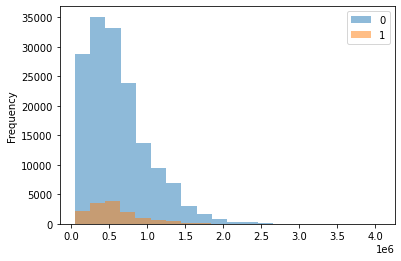

In [ ]:
df.groupby(["TARGET"])["AMT_CREDIT"].plot.hist(bins=20, alpha=0.5, legend=True)

In [ ]:
s, pvalue = stats.mannwhitneyu(df[df["TARGET"]==1]["AMT_CREDIT"]
                , df[df["TARGET"]==0]["AMT_CREDIT"]
                ,alternative='two-sided')
pvalue < 0.05

True

この検定より、債務不履行の有無に関してAMT_CREDITには有意差があることが分かりました。値が小さい方が債務不履行になりやすいという結果なので、問題は借入金の総額ではなく、収入との問題があるのかもしれません。収入AMT_INCOME_TOTALに関して検討してみます。

In [ ]:
df.groupby(["TARGET"])["AMT_INCOME_TOTAL"].mean()

TARGET
0    169058.816794
1    160541.413610
Name: AMT_INCOME_TOTAL, dtype: float64

In [ ]:
df.groupby(["TARGET"])["AMT_INCOME_TOTAL"].median()

TARGET
0    148500.0
1    135000.0
Name: AMT_INCOME_TOTAL, dtype: float64

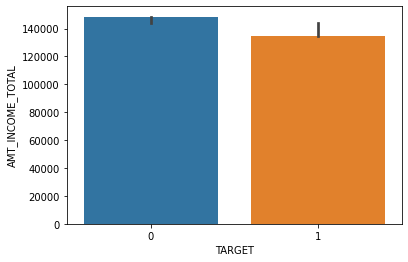

In [ ]:
sns.barplot(x='TARGET', y='AMT_INCOME_TOTAL', data=df, estimator=np.median)

TARGET
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: AMT_INCOME_TOTAL, dtype: object

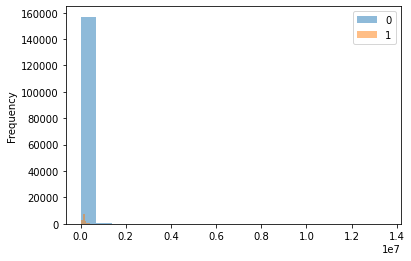

In [ ]:
df.groupby(["TARGET"])["AMT_INCOME_TOTAL"].plot.hist(bins=20, alpha=0.5, legend=True)

TARGET
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: AMT_INCOME_TOTAL, dtype: object

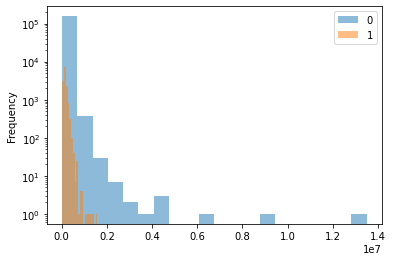

In [ ]:
df.groupby(["TARGET"])["AMT_INCOME_TOTAL"].plot.hist(bins=20, alpha=0.5,log=True, legend=True)
#スケールが見にくいので対数変換

In [ ]:
s, pvalue = stats.mannwhitneyu(df[df["TARGET"]==1]["AMT_INCOME_TOTAL"]
                , df[df["TARGET"]==0]["AMT_INCOME_TOTAL"]
                ,alternative='two-sided')
pvalue < 0.05

True

この検定より、債務不履行の有無に関してAMT_INCOME_TOTALには有意差があることが分かりました。値が小さい方が債務不履行になりやすいという結果なので、収入が少ない人の方が債務不履行になりやすいということが分かりました。ここから、収入が少ない人への適切な融資プランの需要が考えられます。

先ほど予想したように、借入金が多ければ債務不履行になりやすいという訳ではないようなので、収入と借入金の割合について考えてみたいと思います。

In [ ]:
df['Ratio_of_income_to_debt']=df['AMT_CREDIT']/df['AMT_INCOME_TOTAL']
df.groupby(["TARGET"])["Ratio_of_income_to_debt"].mean()

TARGET
0    3.967361
1    3.855420
Name: Ratio_of_income_to_debt, dtype: float64

In [ ]:
df.groupby(["TARGET"])["Ratio_of_income_to_debt"].median()

TARGET
0    3.267273
1    3.257333
Name: Ratio_of_income_to_debt, dtype: float64

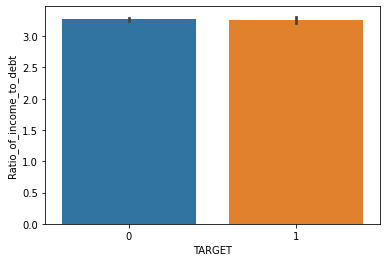

In [ ]:
sns.barplot(x='TARGET', y='Ratio_of_income_to_debt', data=df, estimator=np.median)

TARGET
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Ratio_of_income_to_debt, dtype: object

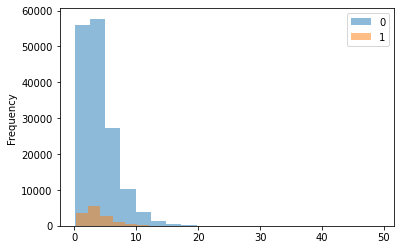

In [ ]:
df.groupby('TARGET')['Ratio_of_income_to_debt'].plot.hist(bins=20, alpha=0.5, legend=True)

In [ ]:
s, pvalue = stats.mannwhitneyu(df[df["TARGET"]==1]["Ratio_of_income_to_debt"]
                , df[df["TARGET"]==0]["Ratio_of_income_to_debt"]
                ,alternative='two-sided')
pvalue < 0.05

False

どうやら、債務不履行かどうかは年収と借入金の比では決定しないようです。収入が少ない人の場合、借入金の割合や額が少なくても債務不履行になるケースが多いのかもしれません。

今回は上手くいきませんでしたが、仮説を立ててデータを色々な角度から分析するのは企業の課題を見つけるのに有効な手段の一つです。

ここまでのデータ分析から、**外部の信用スコアが重要であることや、若者や収入の少ない人は債務不履行者になりやすい課題**が見えてきました。
今回は簡便な方法でEDAを行いましたが、更に深く探索を行うことや、全く別の観点からEDAを行うことは評価に繋がります。

今回はEDAの手段としてLightGBMを用いましたが、この学習結果をモデル構築の一部とすることも可能です。**最終課題では、データ分析結果を可視化して提示し、どのようなことが明らかになったのか示すとともに、機械学習によるモデル構築を行いましょう。この流れに沿って行けば、どのような事業提案を行ったらよいかが見えてくると思います。**

tips:可視化を行う際に、日本語を軸の名前などに記述したい時にはjapanize_matplotlibを用いると便利です。調べてみてください。

最終課題の説得力を上げる一つの方法としては、事業に定量性を持たせることです。機械学習モデルを用いて、例えば今回のケースなら債務不履行者による損失がどれだけ減らせるか示すことができれば、定量性が上がり説得力が増します。


まず、機械学習する前のHome Credit社の損失合計を求めてみます。債務不履行者の合計金額を求めればいいですから、

In [ ]:
loss_sum=df[df["TARGET"]==1]
loss_sum['AMT_CREDIT'].sum()

7665723153.0

これより、通貨単位をドルとして、7665723153ドルの損失があることが分かりました。ここで、今回機械学習で債務不履行者と予測した融資金額の合計を算出します。なお、債務不履行者かどうかは、実際の債務不履行者の割合が8%程度であることを考え、今回は大雑把ですが予測確率が上位の5%より小さいかどうかで判定してみます。

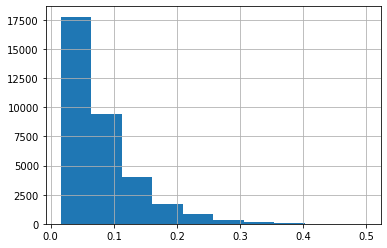

In [ ]:
X_valid['pred']=y_pred
X_valid['pred'].hist()

In [ ]:
threshold=X_valid['pred'].quantile(0.95)
print(threshold)
X_valid.loc[X_valid['pred'] < threshold, 'pred'] = 0
X_valid.loc[X_valid['pred'] >= threshold, 'pred'] = 1

0.19799072077092722


In [ ]:
loss_pred=X_valid[X_valid["pred"]==1]
loss_pred['AMT_CREDIT'].sum()

787740439.5

In [ ]:
787740439.5/0.8

984675549.375

債務不履行者と予測した人への融資金額は787740439.5ドルでした。訓練データ・テストデータの分割(8割と2割)を考慮すると、これらがほぼランダムに分割できているのであれば984675549.375ドルの損失があると言えます。機械学習を用いて債務不履行者と判定した人に融資を行わなければ、これだけの損失を回避することができます。ただし、この計算ではモデルの性能等を全く考慮していないので、やや乱暴な理論と言えます。しかし、ただ機械学習をして債務不履行者を予測します、と事業提案されるよりは具体的で分かりやすい説明になると言えます。

本サンプルでは行っておりませんが、**市場調査を行うことも説得力の観点で大事**です。例えば同業他社ではどのような問題を抱えており、その課題をいかにデータで解決できるか示すことができれば説得力を増すことができます。

以上で最終課題のサンプルとします。

最終課題の評価を上げるには、データ分析を綿密に行うこと、モデルの性能を高めること、斬新な事業を提案すること、隙のない議論に基づいた定量性のある事業を提案することなどが考えられます。また、事業提案ですので、ビジネスモデルキャンバスやリーンキャンバスを用いることも有効だと考えられます。ぜひ調べてみてください。非常にチャレンジングな課題ですが、今まで学んだことを活かしてデータ分析や機械学習を用いた事業を提案して下さい。皆さんの力作をお待ちしております。